<a href="https://colab.research.google.com/github/jamstanleyambe/End-to-End-Dog-Breed-Identification/blob/main/Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐈 End-to-End multil-class Dog Breed Classification

This NoteBook builds an end to end multil-class image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem


> Identifying the bread of a dog given an image of a dog.
if i can take a picture of any dog i want to know what kind of the breed the Dog is.

## 2. Data

>The data we are using is coming from Kaggle dog breed identification competition

## 3. Evaluation

> The Evaluation is a file with prediction probability of each dog breed of each test image

## 4. Features

>Some information about the data:
 * We are dealing with images **(unstructured data)** so it probably best to use deep learning/transfer learning.
 * There are 120 breeds of dogs (this means thee are 120 different classes).
 * There are around 10000 + images in the traing set ( this images has lable beacuse we are using them for the trainig)
 * Tehre are around 10000 + images in the test set, (this images has no lable because we want to predict them)


In [16]:
# import Tensorflow into our colab

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
from IPython.display import Image
print("tensorflow_hub", hub.__version__)
print("tensorflow", tf.__version__)

tensorflow_hub 0.16.1
tensorflow 2.17.1


# Getting Our workPace Ready
* import Tensorflow
* import Tensorflow HandleData
* Make sure we're using GPU

In [3]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


# getting our data ready (turning into Tensorns)
With all machine learning models, our data has to be in numerical format. So that well be doing first Turning our images into Tensors (numerical representation)

In [19]:
# Checkout the Labels of our data
labels_csv = pd.read_csv("/content/drive/MyDrive/dog-breed-identification/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
print(labels_csv.shape)
print(labels_csv.info())
print(labels_csv.describe())

(10222, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


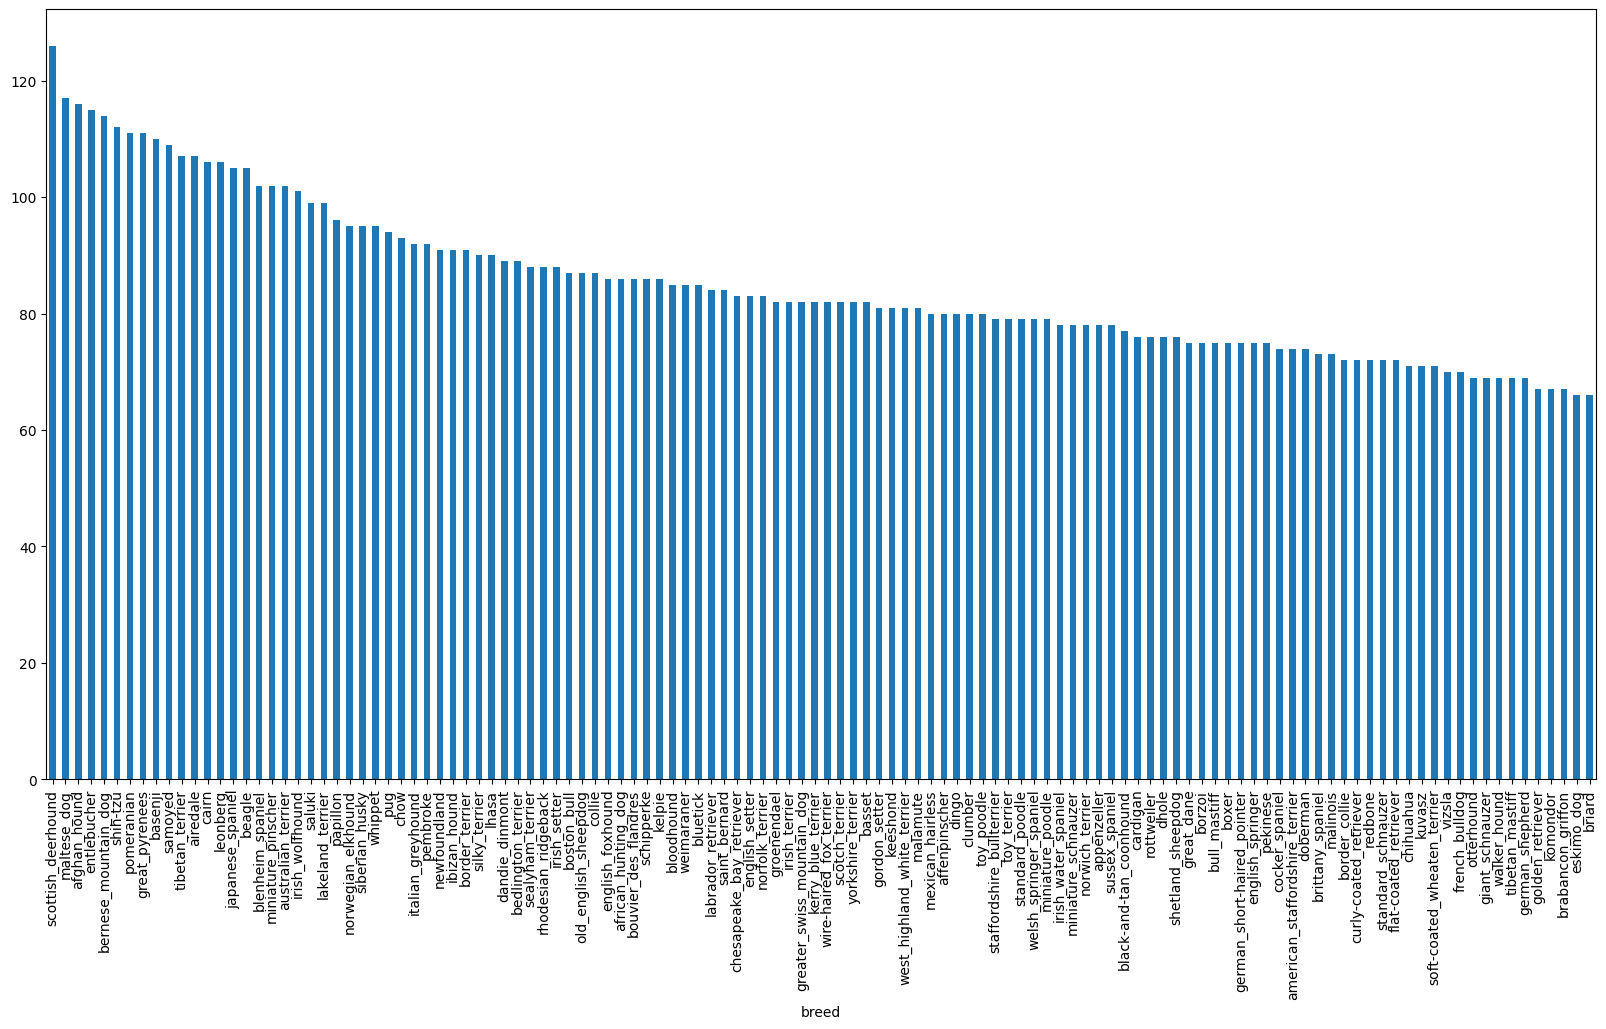

In [10]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [12]:
labels_csv['breed'].value_counts().median()

82.0

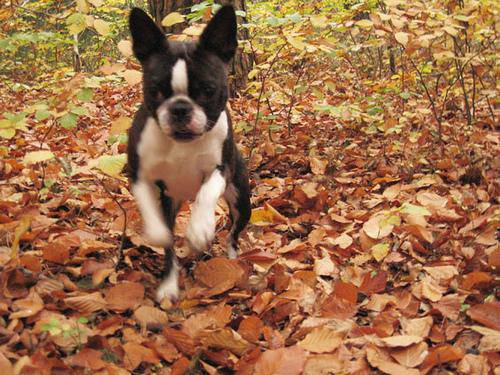

In [22]:
# Lest view our images
Image('/content/drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Getting images and their labels
Lets get all list of our images file pathnames

In [23]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [78]:
#create path name for all image ID
# option 3
filenames3 = []
for image_id in labels_csv['id']:
    filenames3.append(f"/content/drive/MyDrive/dog-breed-identification/train/{image_id}.jpg")
# option 2
filenames2 = [f"/content/drive/MyDrive/dog-breed-identification/train/{image_id}.jpg" for image_id in labels_csv['id']]
# option 1
filenames = ['drive/MyDrive/dog-breed-identification/train/' + image_id + '.jpg' for image_id in labels_csv['id']]

In [79]:
filenames3[:3]

['/content/drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg']

In [76]:
filenames2[:3]

['/content/drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg']

In [77]:
filenames[:3]

['drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg']

# Cheak Whether number of filename matches the actual number of the image files

In [81]:

actual_num_files = len(os.listdir('drive/MyDrive/dog-breed-identification/train'))
actual_num_files

7939

10222

In [66]:
if len(os.listdir('drive/MyDrive/dog-breed-identification/train')) == len(filenames):
  print("filename names matches the actual number of the image files")
else:
  print("filename names does not matches the actual number of the image files")

filename names does not matches the actual number of the image files


In [83]:
created_num_files = len(filenames)
created_num_files

10222